In [45]:
#data preprocessing
import pandas as pd
#Math operations
#pip install numpy==1.15.0
#math operations
import numpy as np

#machine learning
from sklearn.metrics import roc_curve               #ploting 
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.utils import np_utils            #converting data to categorical format, and other data-related utilities.
from keras.models import Sequential         # layer has exactly one input tensor and one output tensor
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
            
from random import shuffle
from tqdm import tqdm                       #progress bar for iterating over a sequence
import scipy                                
import skimage                              #scikit-image
from skimage.transform import resize
import random
from sklearn import metrics                         # classification, regression, clustering, and other machine learning tasks
from sklearn.metrics import classification_report       #information such as precision, recall, F1 score, and support for each class in the classification task

from numpy import loadtxt
from keras.models import load_model

from sklearn.metrics import confusion_matrix

In [46]:
PARA_DIR = "cell_images/cell_images/Parasitized/"
UNIF_DIR =  "cell_images/cell_images/Uninfected/"

In [47]:
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(UNIF_DIR)

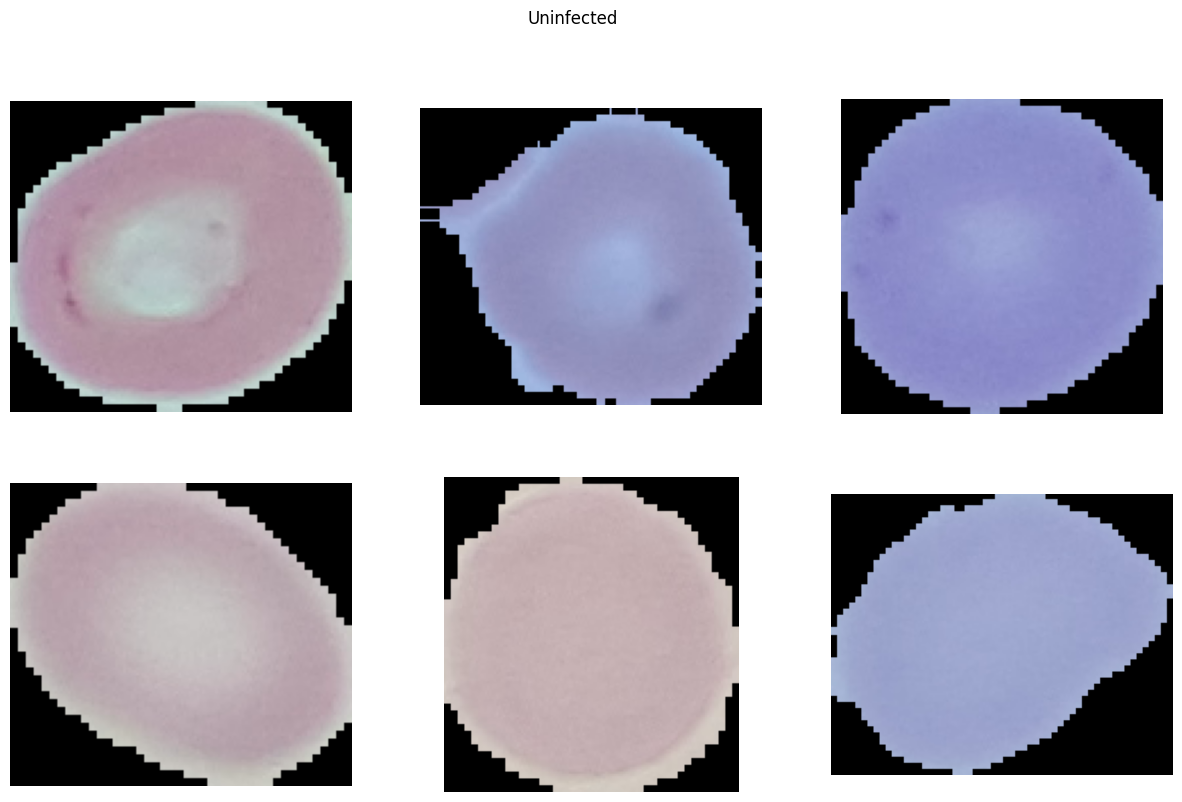

In [48]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/cell_images/Uninfected/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Uninfected')
plt.show()

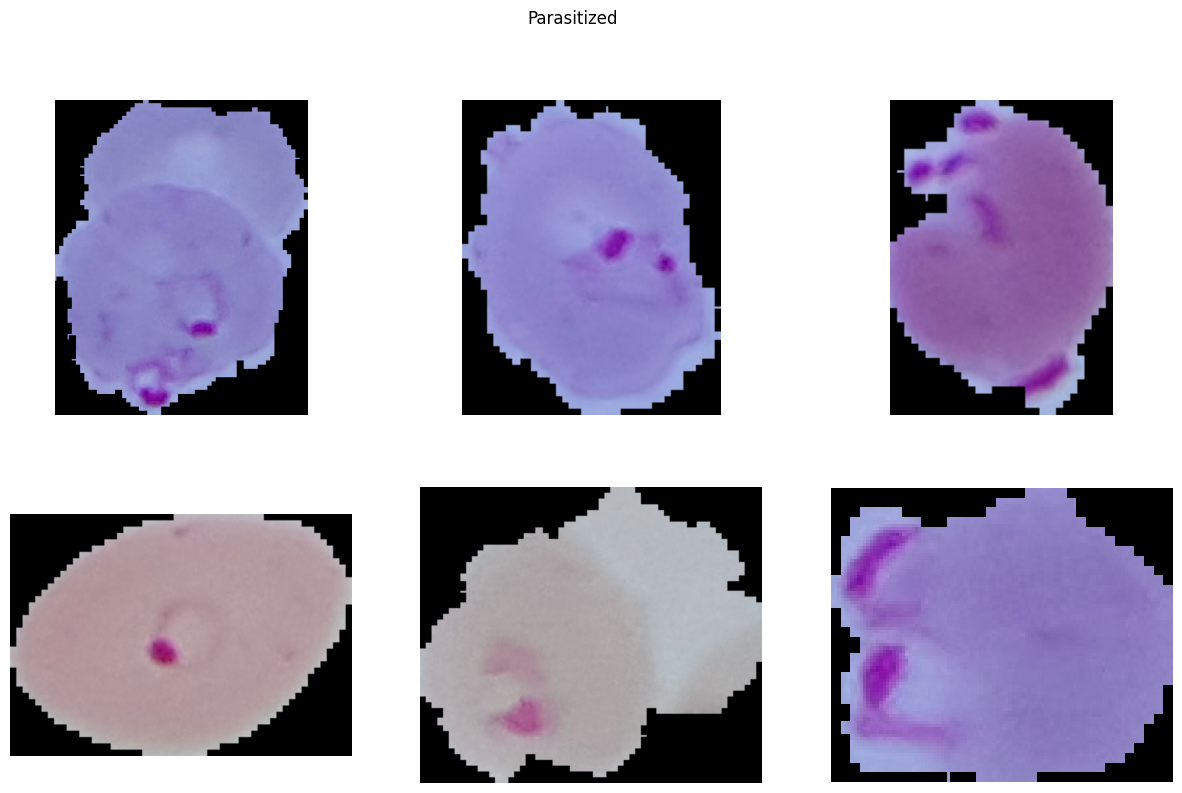

In [49]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/cell_images/Parasitized/'+sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasitized')
plt.show()

In [50]:
#Segmentation
data=[]
labels=[]
Parasitized=os.listdir("cell_images/cell_images/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("cell_images/cell_images/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("Parasitized Done")

Uninfected=os.listdir("cell_images/cell_images/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("cell_images/cell_images/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("Uninfected Done")

Parasitized Done
Uninfected Done


In [51]:
Cells=np.array(data)
labels=np.array(labels)

np.save("Cells",Cells)
np.save("labels",labels)

Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [52]:
#np.save("Cells",Cells)
#np.save("labels",labels)

In [53]:
#Cells=np.load("Cells.npy")
#labels=np.load("labels.npy")

In [54]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

num_classes=len(np.unique(labels))
len_data=len(Cells)

In [55]:
#num_classes=len(np.unique(labels))
#len_data=len(Cells)

In [56]:
(x_train,x_test)=Cells[(int)(0.1*len_data):],Cells[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [57]:
#(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [58]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [59]:
# Set random seed
np.random.seed(0)

In [60]:
#creating sequential model CNN
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        4128      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 12, 12, 32)       

In [61]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [63]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
h=model.fit(x_train,y_train,batch_size=32,callbacks=callbacks, validation_data=(x_test,y_test),epochs=20,verbose=1)

Epoch 1/20
776/776 [==============================] - 48s 60ms/step - loss: 0.3815 - accuracy: 0.8191 - val_loss: 0.1723 - val_accuracy: 0.9270
Epoch 2/20
776/776 [==============================] - 46s 60ms/step - loss: 0.1783 - accuracy: 0.9433 - val_loss: 0.1514 - val_accuracy: 0.9514
Epoch 3/20
776/776 [==============================] - 47s 61ms/step - loss: 0.1654 - accuracy: 0.9502 - val_loss: 0.1483 - val_accuracy: 0.9543
Epoch 4/20
776/776 [==============================] - 47s 60ms/step - loss: 0.1587 - accuracy: 0.9513 - val_loss: 0.1324 - val_accuracy: 0.9608
Epoch 5/20
776/776 [==============================] - 44s 57ms/step - loss: 0.1492 - accuracy: 0.9535 - val_loss: 0.1364 - val_accuracy: 0.9604
Epoch 6/20
776/776 [==============================] - 47s 60ms/step - loss: 0.1456 - accuracy: 0.9535 - val_loss: 0.1302 - val_accuracy: 0.9623
Epoch 7/20
776/776 [==============================] - 46s 60ms/step - loss: 0.1397 - accuracy: 0.9568 - val_loss: 0.1232 - val_accuracy:

In [64]:
from numpy import loadtxt
from keras.models import load_model
model = load_model('.mdl_wts.hdf5')

In [65]:
score=model.evaluate(x_test,y_test)
print(score)

87/87 [==============================] - 1s 12ms/step - loss: 0.1143 - accuracy: 0.9623
[0.11431699991226196, 0.9622504711151123]


In [66]:
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

87/87 [==============================] - 1s 13ms/step - loss: 0.1143 - accuracy: 0.9623

 Test_Accuracy:- 0.9622504711151123


In [67]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

87/87 [==============================] - 1s 16ms/step


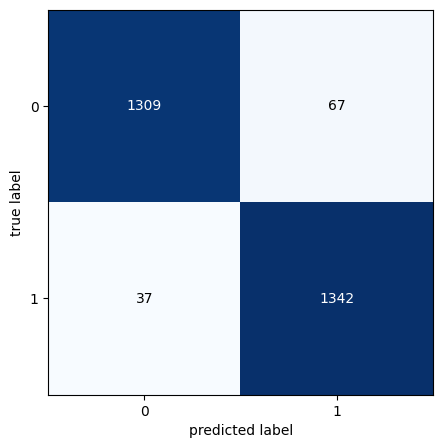

In [68]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [69]:
i=9
pred = model.predict(x_test,batch_size=1)
pred = np.argmax(pred,axis = 1)

2755/2755 [==============================] - 7s 2ms/step


In [70]:
pred[0]

1

In [71]:
!mkdir models_app

A subdirectory or file models_app already exists.


In [72]:
model.save('models_app/my_model.h5')

In [73]:
len(model.layers)

13

In [74]:
x_test.shape[0]

2755

In [75]:
import keras
print(keras.__version__)

2.11.0


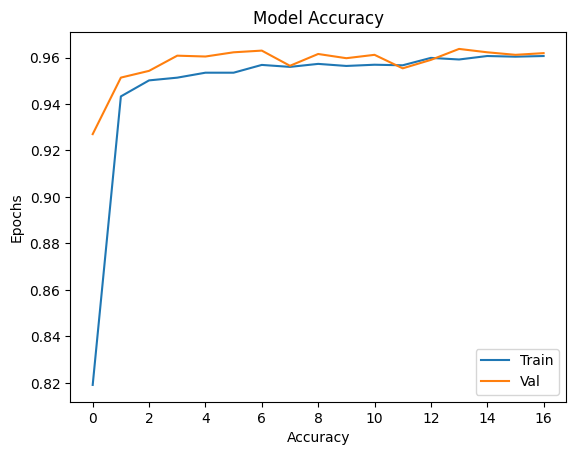

In [76]:
plt.plot(h.history['accuracy'])
plt.plot(h.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [77]:
fpr_keras, tpr_keras, thresholds = roc_curve(y_true.ravel(), pred.ravel())
auc_keras = metrics.auc(fpr_keras, tpr_keras)
auc_keras

0.9622385512757812

In [78]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

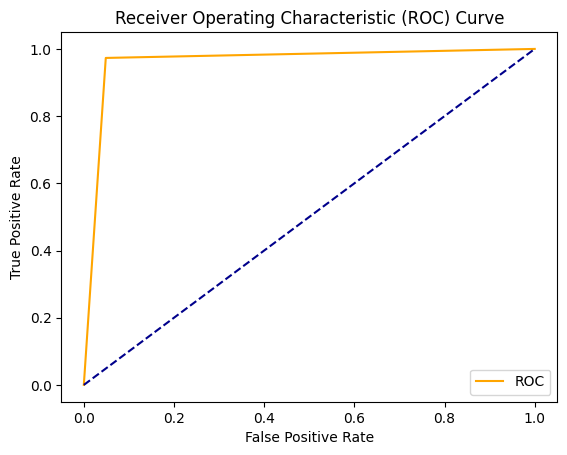

In [79]:
plot_roc_curve(fpr_keras, tpr_keras)

In [80]:
from sklearn.metrics import classification_report

In [81]:

print('{}'.format(classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1376
           1       0.95      0.97      0.96      1379

    accuracy                           0.96      2755
   macro avg       0.96      0.96      0.96      2755
weighted avg       0.96      0.96      0.96      2755



In [82]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
malaria_labels = ['Parasitized','Uninfected']

87/87 [==============================] - 1s 15ms/step


In [83]:
x_test.shape[0]

2755

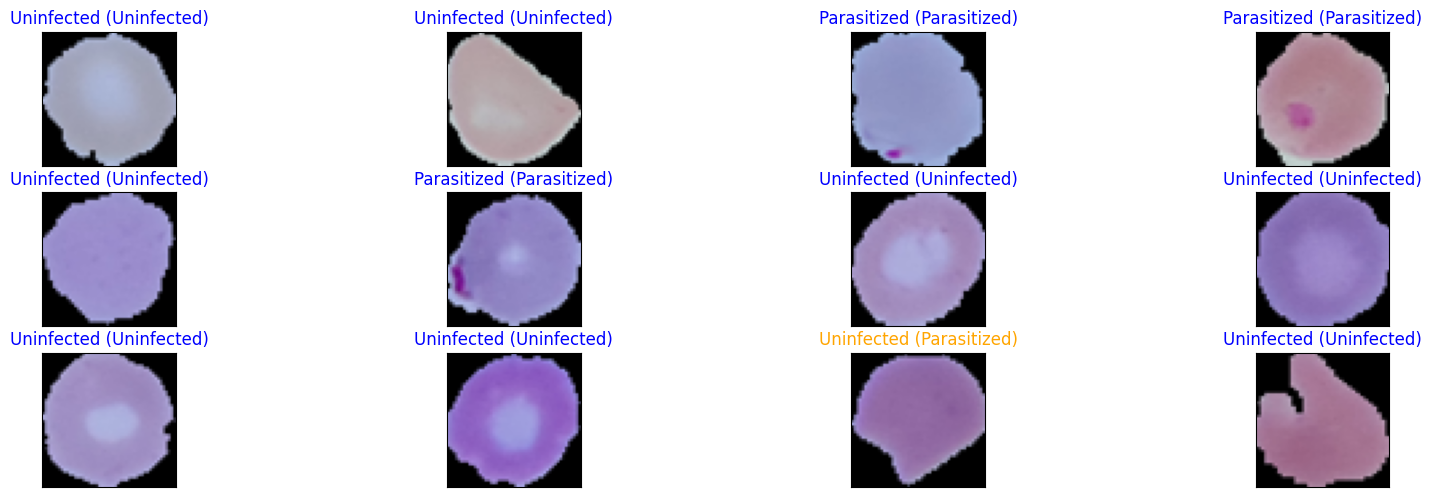

In [84]:
# DESIGN AND METHODOLOGIES
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(malaria_labels[pred_idx], malaria_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

In [85]:
img_path='C1_thinF_IMG_20150604_104722_cell_60.png'

In [86]:
img_path='test_data\Parasitized\C33P1thinF_IMG_20150619_114756a_cell_179.png'

In [87]:
import keras.utils as image
img = image.load_img(img_path, target_size=(50,50)) #target_size must agree with what the trained model expects!!

# Preprocessing the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

preds = model.predict(img)
pred = np.argmax(preds,axis = 1)
print(pred)

# Make prediction
#pred = model_predict(img_path, model)

# Arrange the correct return according to the model. 
# In this model 1 is Pneumonia and 0 is Normal.
str1 = 'Malaria Parasitized'
str2 = 'Normal'
if pred[0] == 0:
    print(str1) 
else:
    print(str2)    


1/1 [==============================] - 0s 22ms/step
[0]
Malaria Parasitized
